# History Matching L96
Author: Redouane Lguensat

Date: 26/07/2021

In [1]:
from L96 import * #https://github.com/raspstephan/Lorenz-Online
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
np.random.seed(42)

X_init = 10 * np.ones(36)
X_init[18] = 10 + 0.01

l96_two = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

In [3]:
l96_two.iterate(10)

  0%|          | 0/10000 [00:00<?, ?it/s]

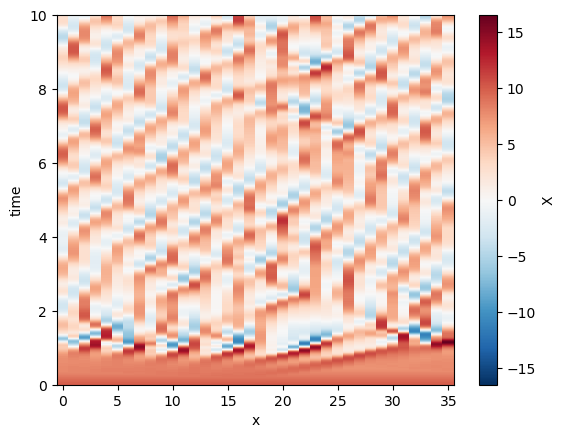

In [4]:
l96_two.history.X.plot()

#### take the last state as an init for a new simulation
since now we are sure that it starts from the attractor

In [5]:
Newinit = l96_two.history.X[-1,:].values
Newinit

array([ 2.60122824, -0.59213617, -1.17373327,  1.84938332,  8.68045117,
        3.46059218,  0.25781228,  1.2653452 ,  1.08225301,  0.8753893 ,
        8.97733208,  6.18802886,  1.94032476,  1.88401847,  4.37917481,
       -1.81942909, 10.94394167,  3.59440247, -1.43808455, -0.99906739,
       -0.49279472,  2.07853127, -0.63479542, 10.33846187,  5.62458241,
        1.20973551,  1.19944234, -3.27853949, -2.96779466,  4.56265636,
        7.60216092,  2.54621466,  0.40105946, -4.41037045,  1.36549073,
        7.4825951 ])

In [6]:
np.random.seed(42)

l96_two_truth = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=Newinit, integration_type='coupled') 

In [7]:
l96_two_truth.iterate(100)

  0%|          | 0/100000 [00:00<?, ?it/s]

This is our ground truth

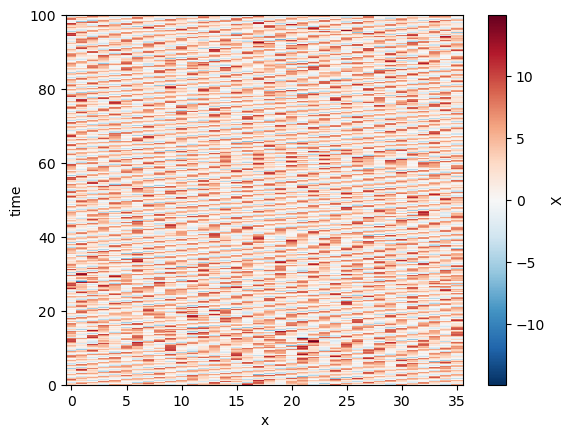

In [8]:
l96_two_truth.history.X.plot()

# Metrics

We will use the 5 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}(X, Y)=\left(\begin{array}{c}
X \\
\bar{Y} \\
X^{2} \\
X \bar{Y}\\
\bar{Y}^{2}
\end{array}\right)
$$

# History Matching

We want to find the parameters (h, F, c, b)

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} - \underbrace{\frac{h c}{b} \Sigma_j Y_{j,k}}_{\text {Coupling}}$

$ \frac{d Y_{j, k}}{d t}=\underbrace{-b c Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{- c Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h c}{b} X_{k}}_{\text {Coupling }}$

# Wave1

calculate metrics for the true trajectory

In [9]:
TrueTraj = l96_two_truth.mean_stats(ax=0)

Define metric 

In [10]:
def metric(params):
    l96param_spinup = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=X_init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param_spinup.iterate(10)
    l96param = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=l96param_spinup.history.X[-1,:].values,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param.iterate(100)
    return l96param.mean_stats(ax=0)

Sanity check with the true params

In [11]:
sancheck = metric(np.array([1,10,10,10]))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
np.mean((TrueTraj - sancheck)**2)

0.0

# Running the 40 simulations in parallel

In [13]:
inputs = pd.read_csv("../Data/df_inputs_newPCA_wave1.csv").values

In [14]:
inputs

array([[ -0.9506537 , -11.25622602,   4.22945245,  -9.95313599],
       [ -0.58927492,   5.88304262,  13.89887497, -11.61067265],
       [  1.39206032,   0.9462625 ,  16.87757738,  -3.71549088],
       [  1.0240202 ,  -9.74291148,   9.64119316, -18.72974204],
       [  1.1653519 ,  -7.78479988,  11.30897114,   8.57620925],
       [ -0.21157391,  10.20842594,   7.55533735,  -2.37051342],
       [  0.68887439,  16.18838155,   9.05736125,   9.31336911],
       [  1.59755322, -18.8017093 ,   6.72280707,  -6.31128218],
       [ -0.15179771,  15.14174447,  16.47321981,  12.53239196],
       [  0.80961799,   3.69544835,   8.32485719,  -0.24000554],
       [ -1.2069505 ,   7.32342558,  13.01020798,   0.64984322],
       [ -0.36836619,  -6.61934018,  14.46395782,  10.49688438],
       [ -0.45301647,   8.74718163,   2.3901988 ,  19.44531702],
       [ -0.0443946 ,  -4.71881111,   5.23100374,  16.32057728],
       [  0.98206247,   1.76183827,  19.98536436,   1.66552631],
       [  1.46358646,  12

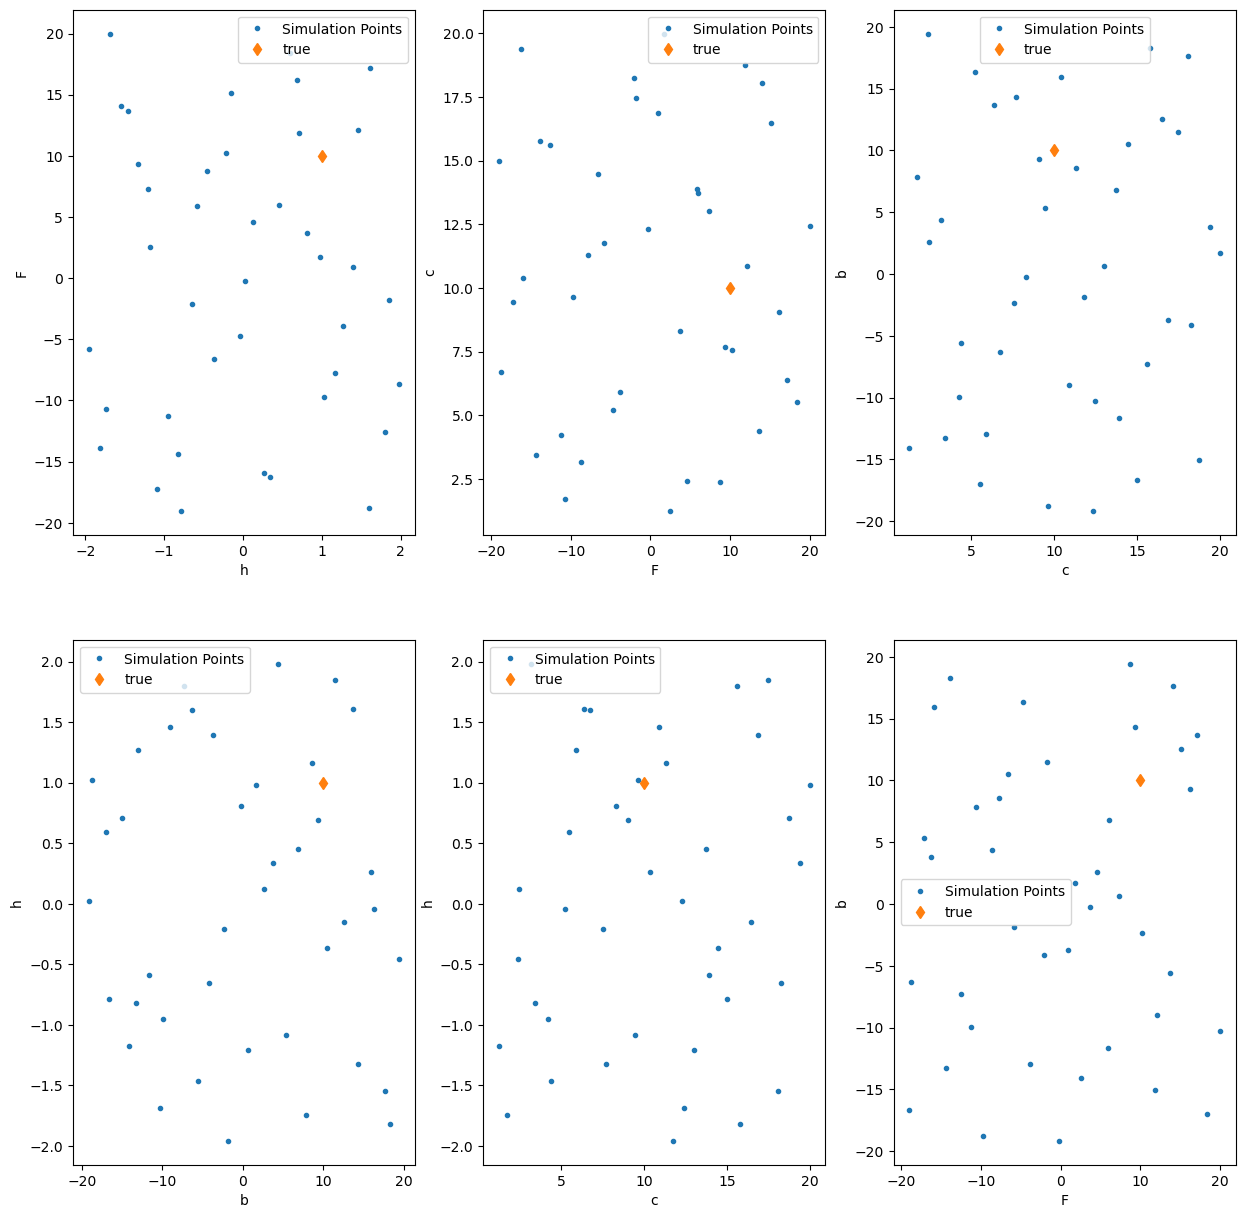

In [15]:
plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs[:,1], inputs[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs[:,0], inputs[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs[:,2], inputs[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs[:,3], inputs[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs[:,2], inputs[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs[:,1], inputs[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [16]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_cores

48

In [17]:
import joblib
joblib.__version__

'1.1.0'

In [18]:
%%time

#feel free to use a higher n_jobs if you can afford to
results = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs) 

targets = np.array(results)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:43<00:00, 2317.02it/s]

CPU times: user 807 ms, sys: 940 ms, total: 1.75 s
Wall time: 5min 6s


In [19]:
inputs = inputs[np.all(np.isfinite(targets), axis=1)]
targets = targets[np.all(np.isfinite(targets), axis=1)]

In [20]:
targets.shape, inputs.shape

((40, 180), (40, 4))

# pca

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduceL96pca(vector):   
    scaler = StandardScaler().fit(vector)
    datascaled = scaler.transform(vector)
    TrueTrajscaled = scaler.transform(TrueTraj[None,:])
    ###########
    pca = PCA(n_components=0.99, svd_solver = 'full')
    pca.fit(datascaled)
    reduceddata = pca.transform(datascaled)
    reducedTrueTraj = pca.transform(TrueTrajscaled)
    return reduceddata, reducedTrueTraj, scaler, pca

In [22]:
targetsreduced, Obsreduced, sc, pc = reduceL96pca(targets)
targetsreduced.shape, Obsreduced.shape

((40, 8), (1, 8))

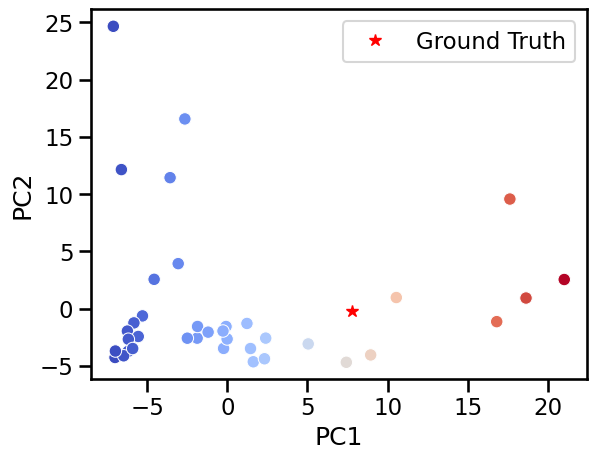

In [23]:
sns.set_context("talk")

sns.scatterplot(x=targetsreduced[:,0],y=targetsreduced[:,1],
                hue=targetsreduced[:,0], palette='coolwarm', legend=False)
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*', label='Ground Truth')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

### save dataframes

In [24]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced[:,i]
df_metrics.to_csv('../Data/df_metrics_newPCA_wave1.csv', index=False)

In [25]:
df_metrics

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
0,-1.881128,-2.587089,7.057956,4.762976,-2.370155,1.393523,-2.553699,0.904506
1,-0.232703,-3.483759,-0.937266,-4.448580,2.100872,0.689894,0.234810,-0.468663
2,-5.945210,-3.315966,0.833109,-2.905718,1.473949,0.149354,-0.724597,-0.343617
3,-5.292283,-0.642532,-0.252943,0.555977,-4.648155,-1.299901,1.187096,-0.101181
4,-5.825017,-1.254328,4.749705,1.212741,1.963864,2.167966,4.677178,3.797906
5,10.539052,0.961140,4.246149,-8.823718,0.266556,-0.089352,1.357544,-0.759590
6,16.801263,-1.145043,2.198670,-3.404265,-2.163872,2.101785,1.442820,-0.482160
7,-2.647914,16.562494,-4.820486,5.288275,-2.100565,-8.553341,-1.161161,-0.540118
8,7.422517,-4.694735,-9.384765,3.203175,-0.780442,2.061363,1.521818,-0.462475
9,-5.978554,-3.258419,0.871710,-2.933452,1.383280,0.127273,-0.693985,-0.357224


In [26]:
df_obs_nonoise = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_obs_nonoise['pca_'+str(i)] = Obsreduced[:,i]
df_obs_nonoise.to_csv('../Data/df_obs_nonoise_newPCA_wave1.csv', index=False)

## 2) wave 2

In [27]:
inputs2 = pd.read_csv("../Data/exp_TuningL94_newPCA_wave2.csv").values

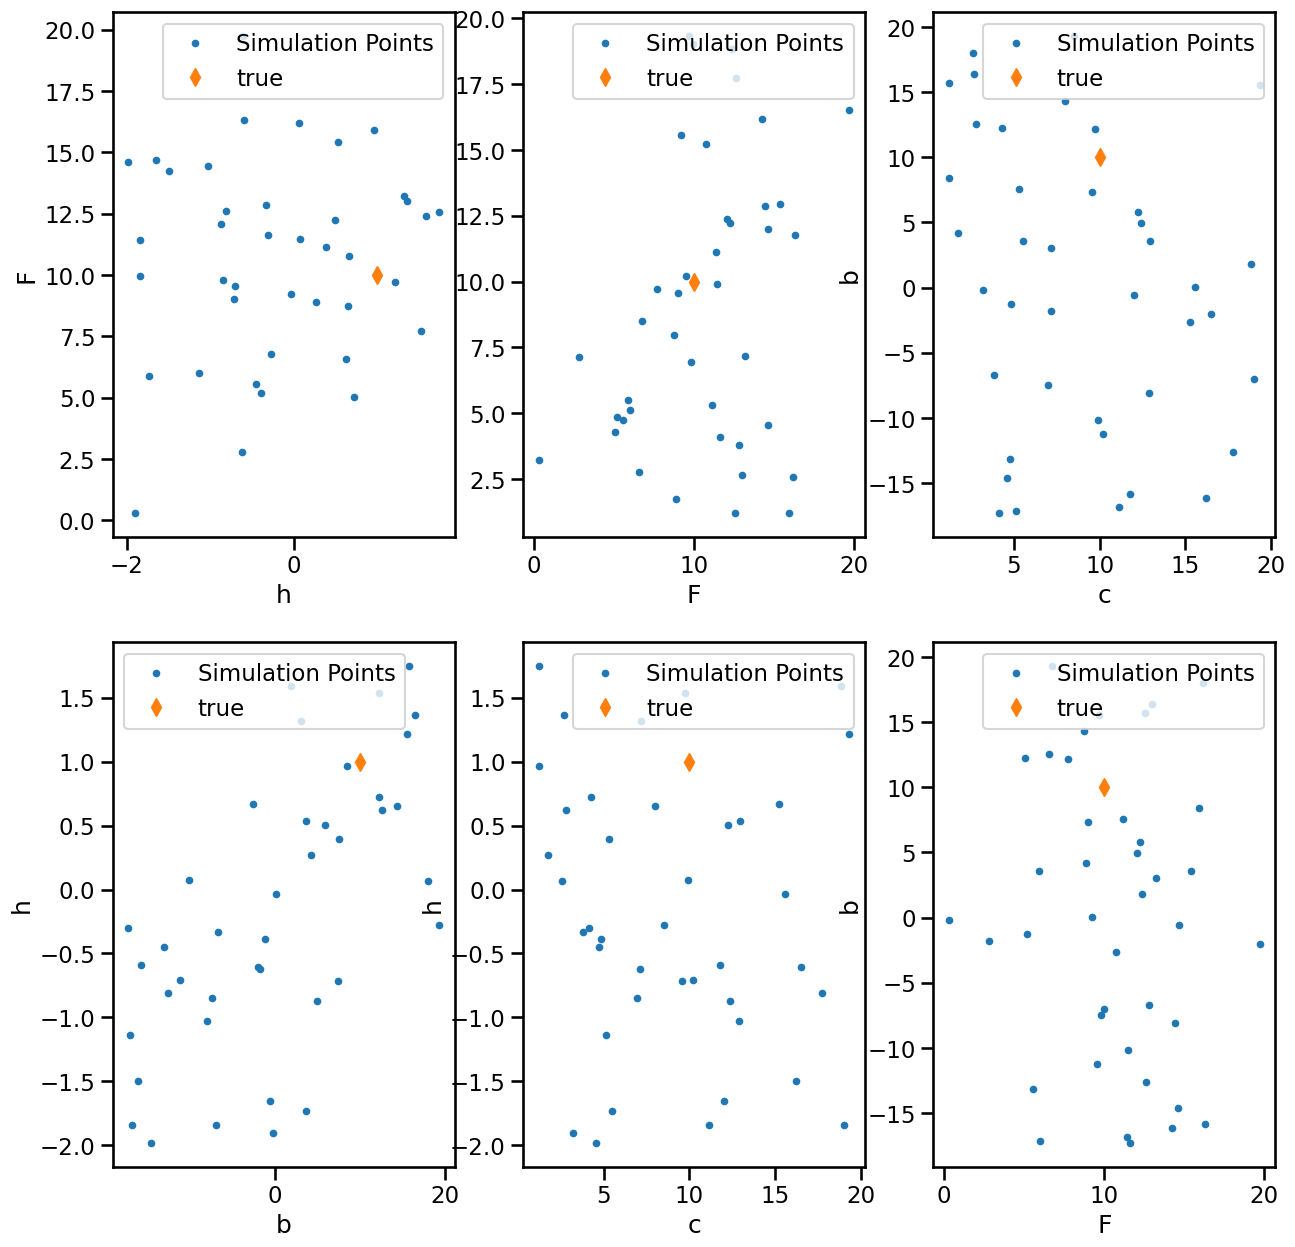

In [28]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs2[:,1], inputs2[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs2[:,0], inputs2[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs2[:,2], inputs2[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs2[:,3], inputs2[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs2[:,2], inputs2[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs2[:,1], inputs2[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [29]:
inputs2.shape

(40, 4)

In [30]:
%%time

results2 = Parallel(n_jobs=20, verbose=1)(delayed(metric)(i) for i in inputs2)

targets2 = np.array(results2)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


  0%|          | 0/10000 [00:00<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2366.19it/s]

100%|██████████| 100000/100000 [00:42<00:00, 2352.25it/s]

CPU times: user 820 ms, sys: 355 ms, total: 1.18 s
Wall time: 2min 44s


[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:  2.7min finished


In [31]:
inputs2 = inputs2[np.all(np.isfinite(targets2), axis=1)]
targets2 = targets2[np.all(np.isfinite(targets2), axis=1)]

In [32]:
def reduceL96pca_usingwave1(vector, scaler, pca): 
    datascaled = scaler.transform(vector)
    return pca.transform(datascaled)

In [33]:
targetsreduced2 = reduceL96pca_usingwave1(targets2, sc, pc)
targetsreduced2.shape

(40, 8)

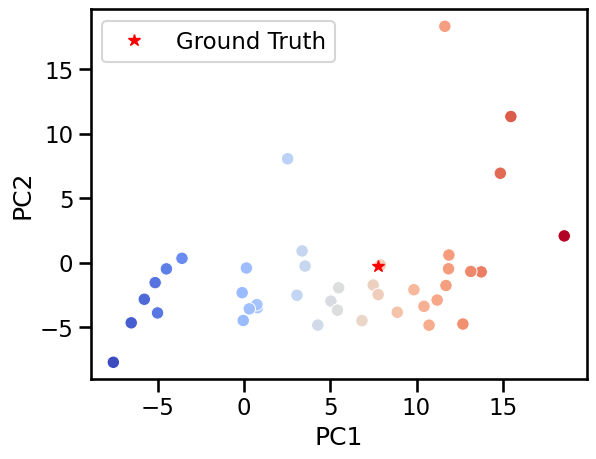

In [34]:
sns.set_context("talk")

sns.scatterplot(x=targetsreduced2[:,0],y=targetsreduced2[:,1],
                hue=targetsreduced2[:,0], palette='coolwarm', legend=False)
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*', label='Ground Truth')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

In [35]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced2.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced2[:,i]
df_metrics.to_csv('../Data/df_metrics_newPCA_wave2.csv', index=False)

# wave3

In [36]:
inputs3 = pd.read_csv("../Data/exp_TuningL94_newPCA_wave3.csv").values

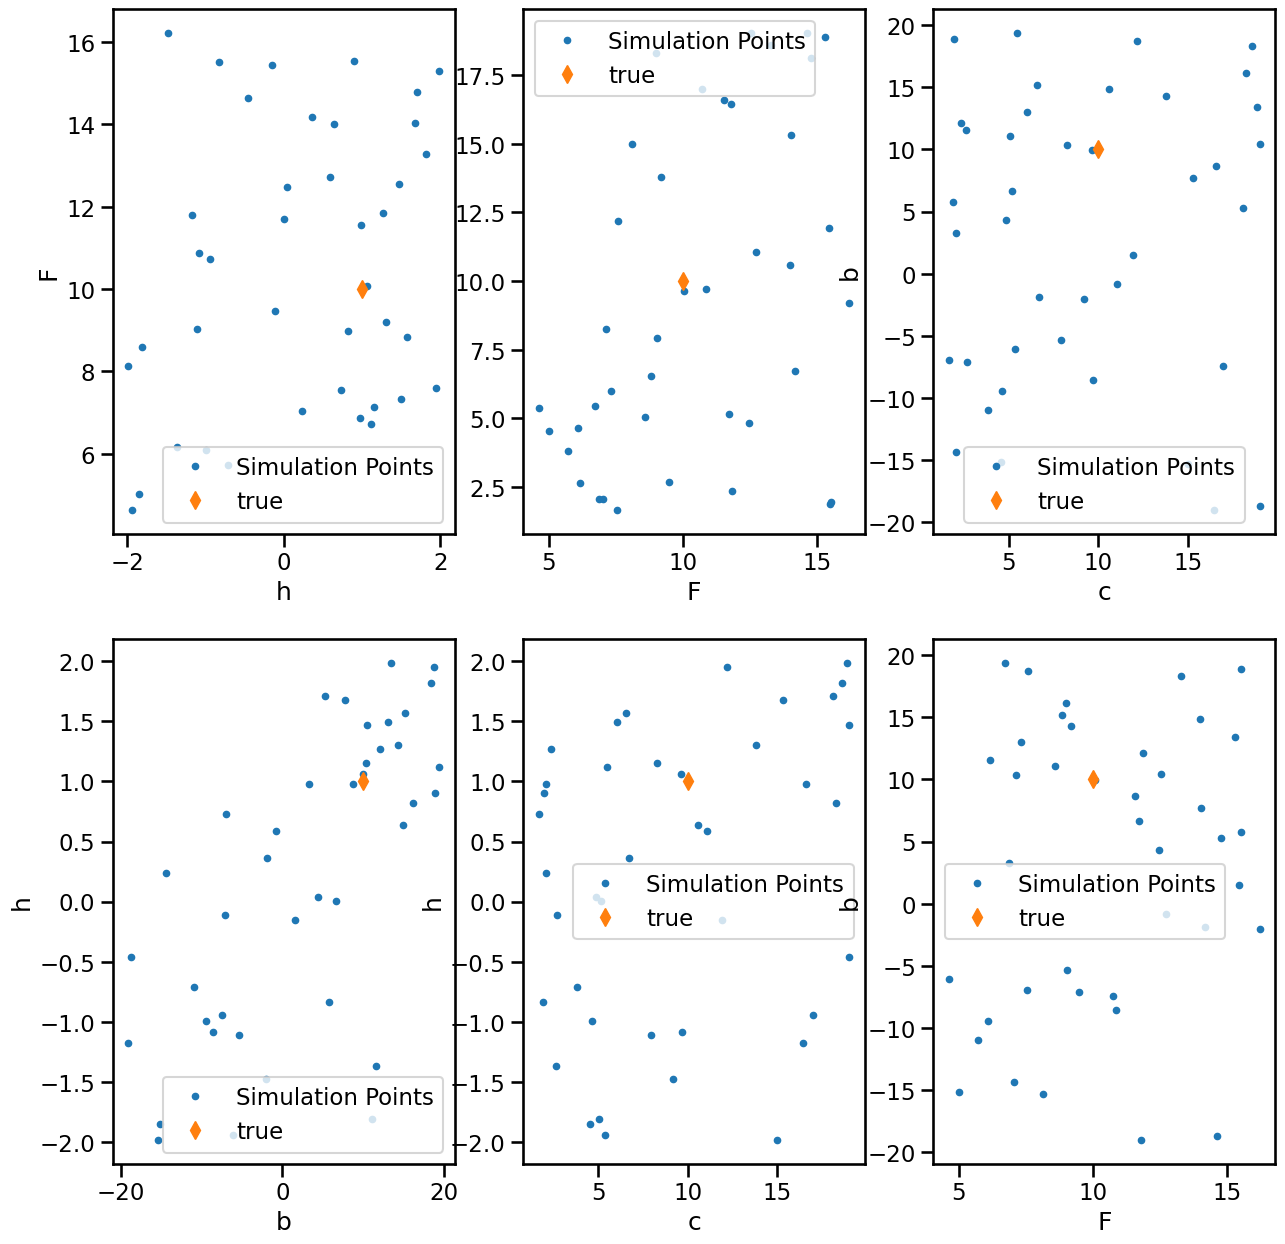

In [37]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs3[:,1], inputs3[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs3[:,0], inputs3[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs3[:,2], inputs3[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs3[:,3], inputs3[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs3[:,2], inputs3[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs3[:,1], inputs3[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [38]:
inputs3.shape

(40, 4)

In [39]:
%%time

results3 = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs3)

targets3 = np.array(results3)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:43<00:00, 2299.52it/s]

CPU times: user 859 ms, sys: 301 ms, total: 1.16 s
Wall time: 2min 25s


In [40]:
inputs3.shape, targets3.shape

((40, 4), (40, 180))

In [41]:
inputs3 = inputs3[np.all(np.isfinite(targets3), axis=1)]
targets3 = targets3[np.all(np.isfinite(targets3), axis=1)]

In [42]:
inputs3.shape, targets3.shape

((40, 4), (40, 180))

In [43]:
targetsreduced3 = reduceL96pca_usingwave1(targets3, sc, pc)
targetsreduced3.shape

(40, 8)

In [44]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced3.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced3[:,i]
df_metrics.to_csv('../Data/df_metrics_newPCA_wave3.csv', index=False)

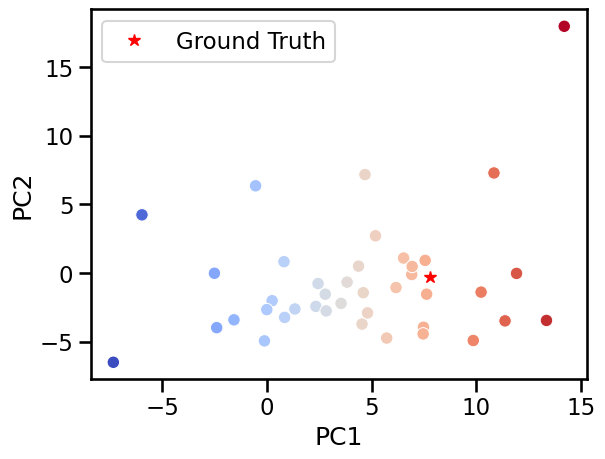

In [45]:
sns.set_context("talk")

sns.scatterplot(x=targetsreduced3[:,0],y=targetsreduced3[:,1],
                hue=targetsreduced3[:,0], palette='coolwarm', legend=False)
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*', label='Ground Truth')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

## wave4

In [47]:
inputs4 = pd.read_csv("../Data/exp_TuningL94_newPCA_wave4.csv").values

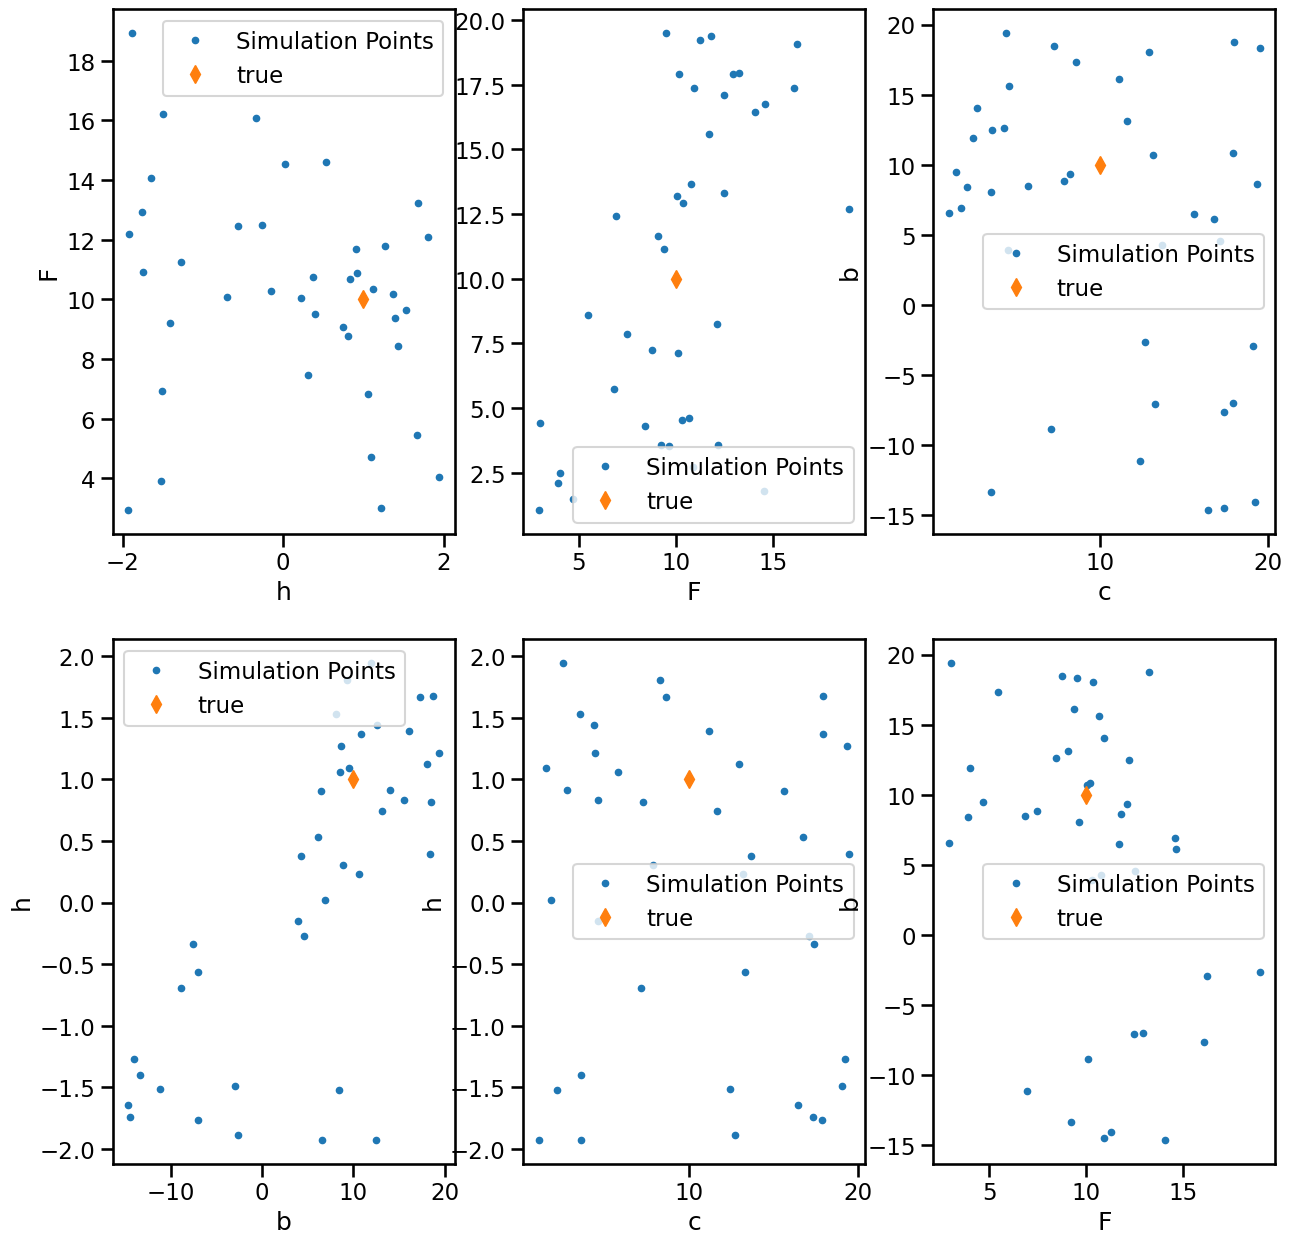

In [48]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs4[:,1], inputs4[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs4[:,0], inputs4[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs4[:,2], inputs4[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs4[:,3], inputs4[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs4[:,2], inputs4[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs4[:,1], inputs4[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [49]:
%%time

results4 = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs4)

targets4 = np.array(results4)

100%|██████████| 100000/100000 [00:42<00:00, 2368.63it/s]

CPU times: user 622 ms, sys: 1.5 s, total: 2.12 s
Wall time: 2min 50s


In [50]:
inputs4 = inputs4[np.all(np.isfinite(targets4), axis=1)]
targets4 = targets4[np.all(np.isfinite(targets4), axis=1)]

In [51]:
inputs4.shape, targets4.shape

((40, 4), (40, 180))

In [52]:
targetsreduced4 = reduceL96pca_usingwave1(targets4, sc, pc)
targetsreduced4.shape

(40, 8)

In [53]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced4.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced4[:,i]
df_metrics.to_csv('../Data/df_metrics_newPCA_wave4.csv', index=False)

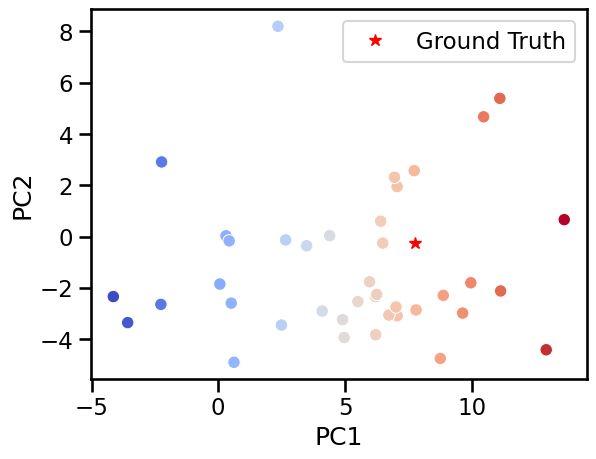

In [54]:
sns.set_context("talk")

sns.scatterplot(x=targetsreduced4[:,0],y=targetsreduced4[:,1],
                hue=targetsreduced4[:,0], palette='coolwarm', legend=False)
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*', label='Ground Truth')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

## wave5

In [55]:
inputs5 = pd.read_csv("../Data/exp_TuningL94_newPCA_wave5.csv").values

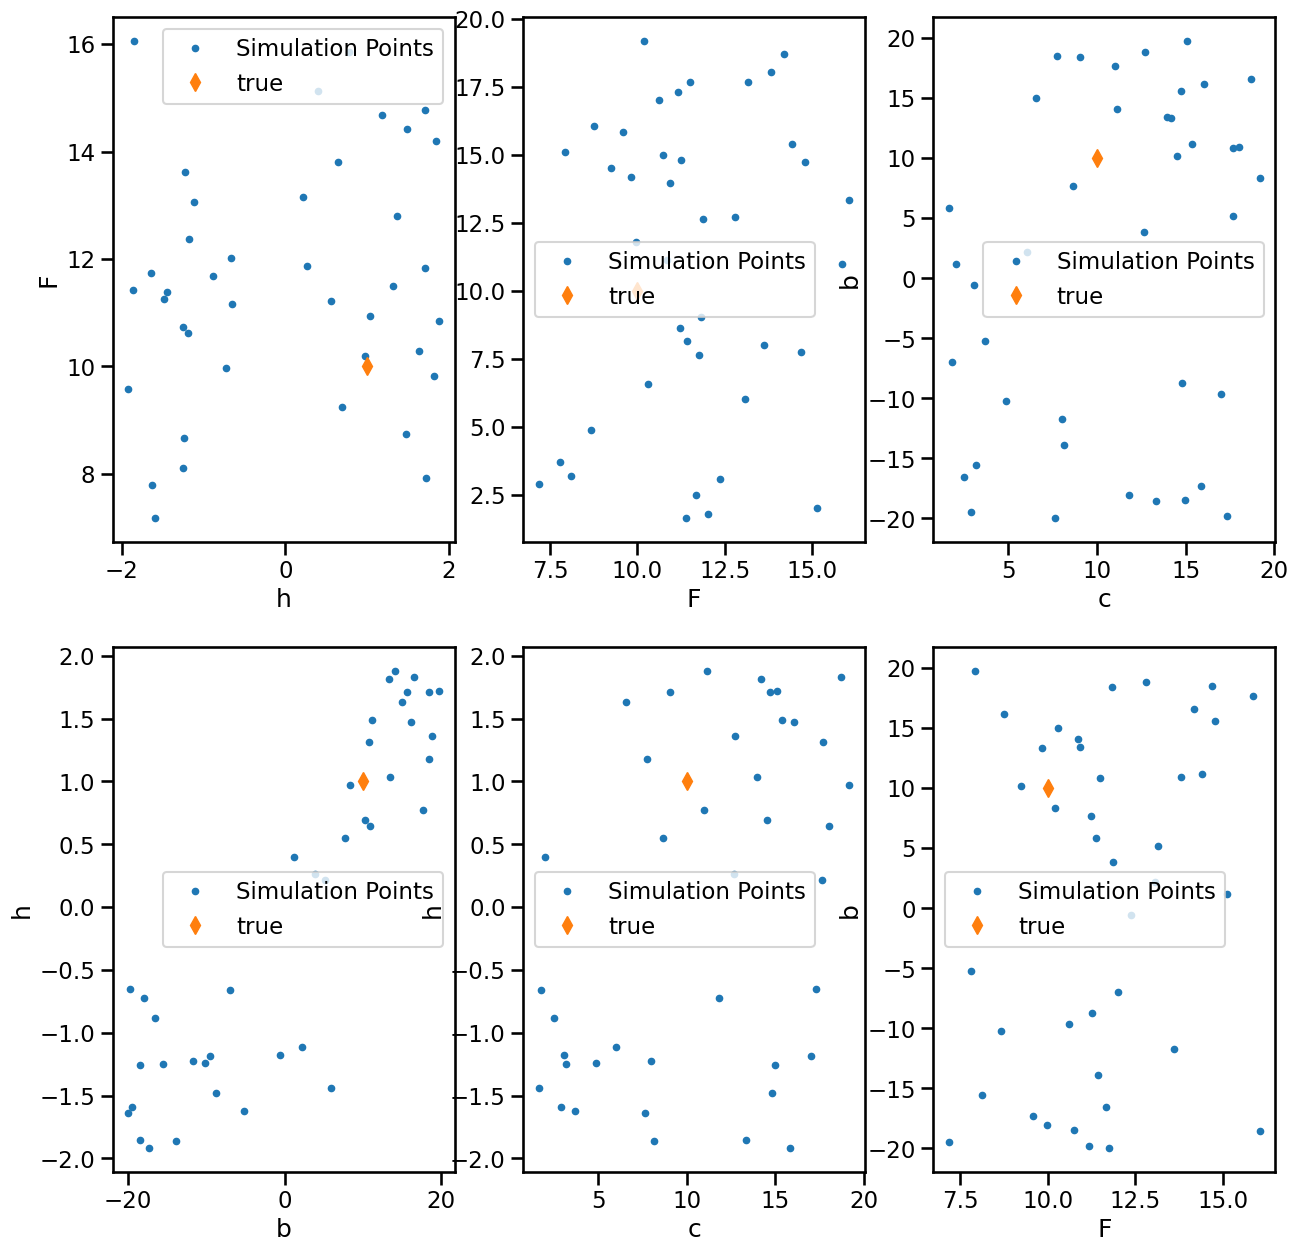

In [56]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs5[:,1], inputs5[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs5[:,0], inputs5[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs5[:,2], inputs5[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs5[:,3], inputs5[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs5[:,2], inputs5[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs5[:,1], inputs5[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [58]:
%%time

results5 = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs5)

targets5 = np.array(results5)

100%|██████████| 100000/100000 [00:41<00:00, 2423.02it/s]

CPU times: user 817 ms, sys: 1.28 s, total: 2.1 s
Wall time: 2min 45s


In [59]:
inputs5 = inputs5[np.all(np.isfinite(targets5), axis=1)]
targets5 = targets5[np.all(np.isfinite(targets5), axis=1)]

In [60]:
inputs5.shape, targets5.shape

((40, 4), (40, 180))

In [61]:
targetsreduced5 = reduceL96pca_usingwave1(targets5, sc, pc)
targetsreduced5.shape

(40, 8)

In [62]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced5.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced5[:,i]
df_metrics.to_csv('../Data/df_metrics_newPCA_wave5.csv', index=False)

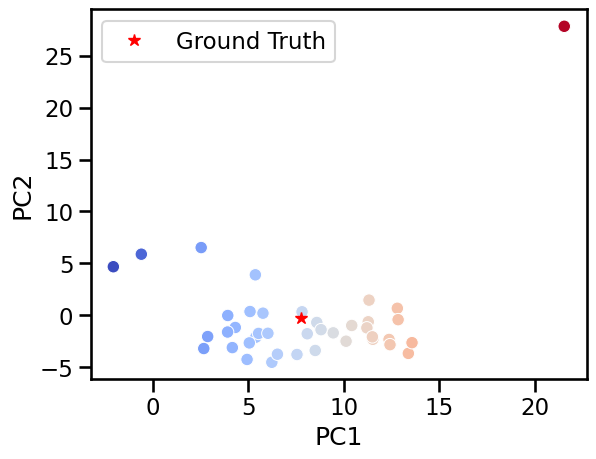

In [63]:
sns.set_context("talk")

sns.scatterplot(x=targetsreduced5[:,0],y=targetsreduced5[:,1],
                hue=targetsreduced5[:,0], palette='coolwarm', legend=False)
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*', label='Ground Truth')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

## wave6

In [64]:
inputs6 = pd.read_csv("../Data/exp_TuningL94_newPCA_wave6.csv").values

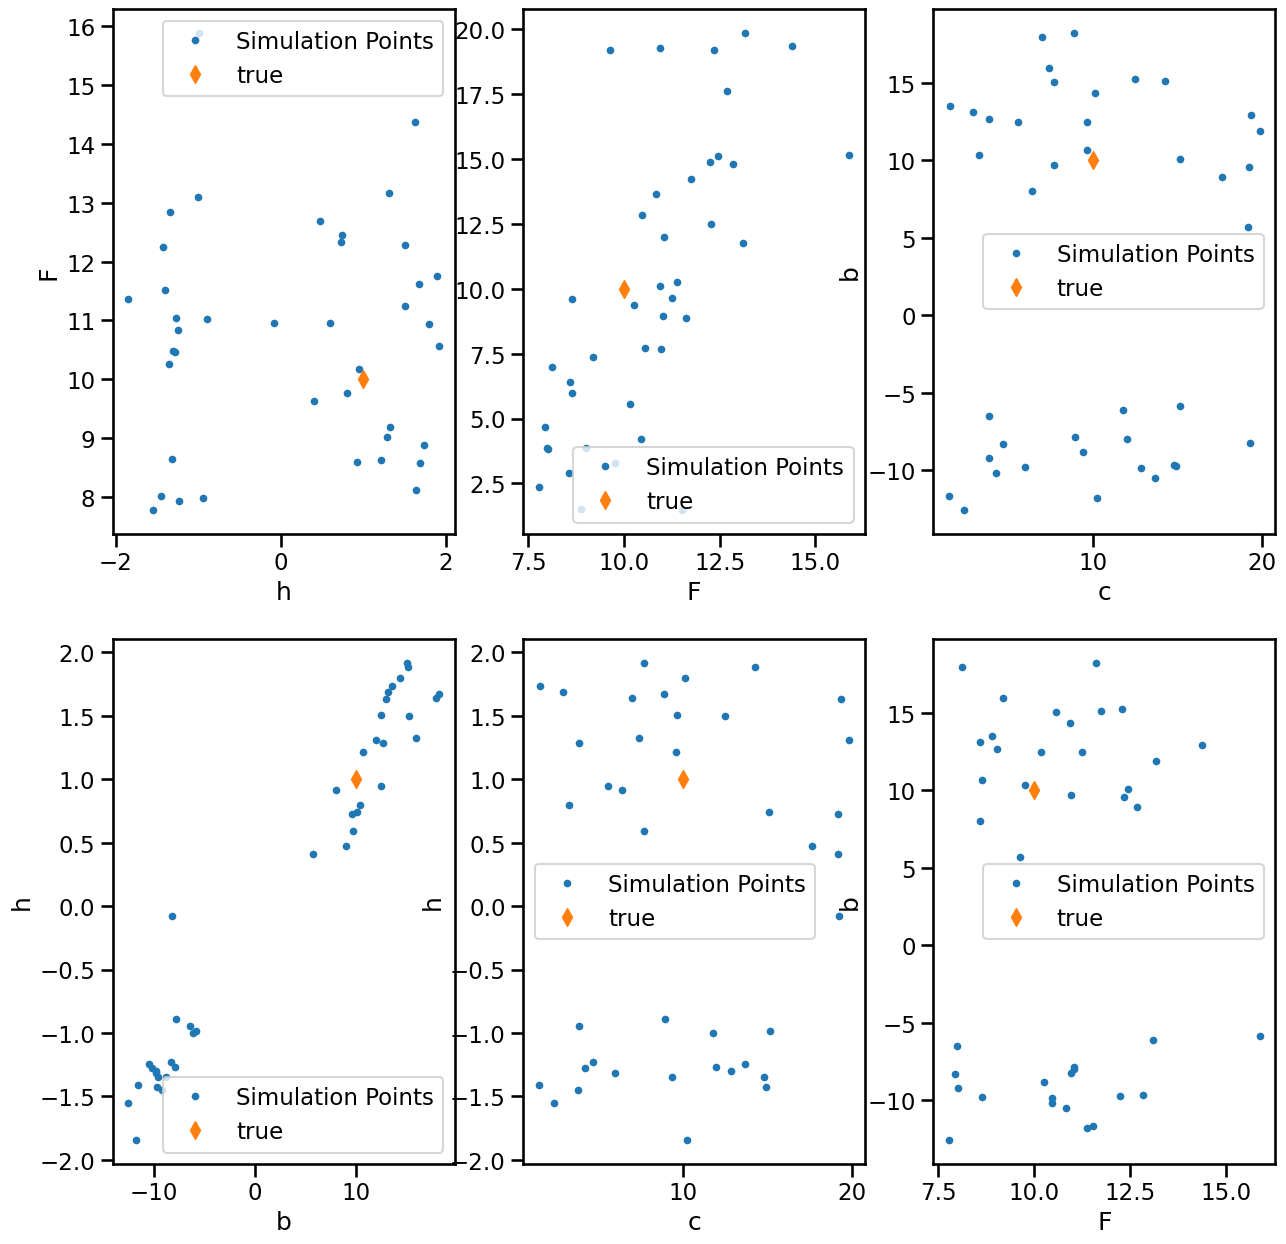

In [65]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs6[:,1], inputs6[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs6[:,0], inputs6[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs6[:,2], inputs6[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs6[:,3], inputs6[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs6[:,2], inputs6[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs6[:,1], inputs6[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [66]:
%%time

results6 = Parallel(n_jobs=20)(delayed(metric)(i) for i in inputs6)

targets6 = np.array(results6)



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 57%|█████▋    | 5748/10000 [00:02<00:01, 2414.00it/s]]

100%|██████████| 100000/100000 [00:42<00:00, 2376.35it/s]

CPU times: user 793 ms, sys: 274 ms, total: 1.07 s
Wall time: 3min 24s


In [67]:
inputs6 = inputs6[np.all(np.isfinite(targets6), axis=1)]
targets6 = targets6[np.all(np.isfinite(targets6), axis=1)]

In [68]:
inputs6.shape, targets6.shape

((40, 4), (40, 180))

In [69]:
targetsreduced6 = reduceL96pca_usingwave1(targets6, sc, pc)
targetsreduced6.shape

(40, 8)

In [70]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced6.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced6[:,i]
df_metrics.to_csv('../Data/df_metrics_newPCA_wave6.csv', index=False)

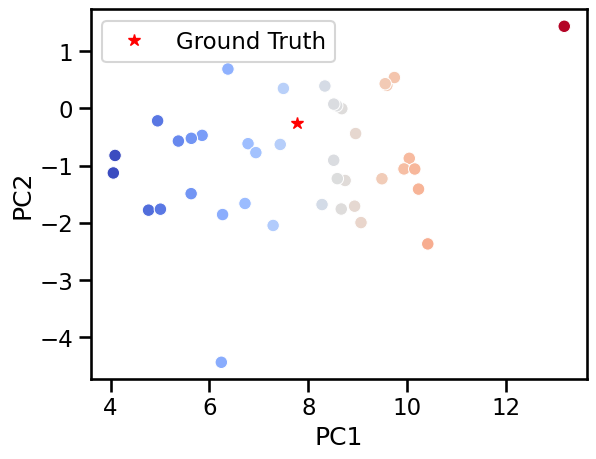

In [72]:
sns.set_context("talk")

sns.scatterplot(x=targetsreduced6[:,0],y=targetsreduced6[:,1],
                hue=targetsreduced6[:,0], palette='coolwarm', legend=False)
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*', label='Ground Truth')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Simulate the L96 configurations

In [73]:
def simulate(params):
    l96param_spinup = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=X_init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param_spinup.iterate(10)
    l96param = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=l96param_spinup.history.X[-1,:].values,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param.iterate(100)
    return l96param

In [75]:
configs = pd.read_csv("../Data/finaltestpoints_newPCA.csv").values
configs.tolist()

[[0.988657254077621, 11.8984002436668, 16.2083968428199, 9.1688071349612],
 [1.15251025059426, 8.93587769098491, 3.93565146713143, 10.333389043069],
 [0.576989775734973, 10.3105499498746, 11.8991102985588, 6.89070230014698],
 [0.921710557340596, 10.3128967365351, 10.2755615952601, 9.35218112827361],
 [1.8693471425848, 11.5222041488374, 19.033968446175, 15.6549173352702]]

In [76]:
simus = [simulate(i) for i in configs.tolist()]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [77]:
simus_metrics = [ii.mean_stats(ax=0) for ii in simus]

In [78]:
simus_metrics = np.array(simus_metrics)
simus_metrics.shape

(5, 180)

In [79]:
simusreduced = reduceL96pca_usingwave1(simus_metrics, sc, pc)
simusreduced.shape

(5, 8)

In [81]:
simus_df = pd.DataFrame()

for i in range(simusreduced.shape[1]):
    simus_df['PC'+str(i+1)] = simusreduced[:,i]
    
#simus_df.to_csv('../Data/configs_metrics_newPCA.csv', index=False)

In [82]:
simus_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,8.123430,0.334787,2.127591,-7.593074,0.937362,-0.242858,1.155723,-0.601844
1,8.442181,0.379103,2.316926,-7.109343,0.956554,-0.200357,1.015959,-0.581211
2,8.031852,-0.254196,2.417689,-7.899954,0.505195,0.167008,1.355031,-0.726655
3,7.653799,-0.220599,1.920868,-7.116815,0.796866,0.054019,1.132908,-0.665300
4,4.084212,-0.817483,1.028517,-6.213245,1.382244,-0.183702,0.691265,-0.558141


### add obs vector

In [83]:
simus_df.loc[len(simus_df)]=list(Obsreduced[0,:])

In [84]:
simus_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,8.123430,0.334787,2.127591,-7.593074,0.937362,-0.242858,1.155723,-0.601844
1,8.442181,0.379103,2.316926,-7.109343,0.956554,-0.200357,1.015959,-0.581211
2,8.031852,-0.254196,2.417689,-7.899954,0.505195,0.167008,1.355031,-0.726655
3,7.653799,-0.220599,1.920868,-7.116815,0.796866,0.054019,1.132908,-0.665300
4,4.084212,-0.817483,1.028517,-6.213245,1.382244,-0.183702,0.691265,-0.558141
5,7.768862,-0.253905,1.701829,-7.123599,0.903411,0.073937,1.147159,-0.603011


In [85]:
simusdftranspose = simus_df.T
simusdftranspose.columns = ['config1', 'config2', 'config3', 'config4', 'config5', 'Obs']
simusdftranspose

,config1,config2,config3,config4,config5,Obs
PC1,8.123430,8.442181,8.031852,7.653799,4.084212,7.768862
PC2,0.334787,0.379103,-0.254196,-0.220599,-0.817483,-0.253905
PC3,2.127591,2.316926,2.417689,1.920868,1.028517,1.701829
PC4,-7.593074,-7.109343,-7.899954,-7.116815,-6.213245,-7.123599
PC5,0.937362,0.956554,0.505195,0.796866,1.382244,0.903411
PC6,-0.242858,-0.200357,0.167008,0.054019,-0.183702,0.073937
PC7,1.155723,1.015959,1.355031,1.132908,0.691265,1.147159
PC8,-0.601844,-0.581211,-0.726655,-0.665300,-0.558141,-0.603011


<AxesSubplot:>

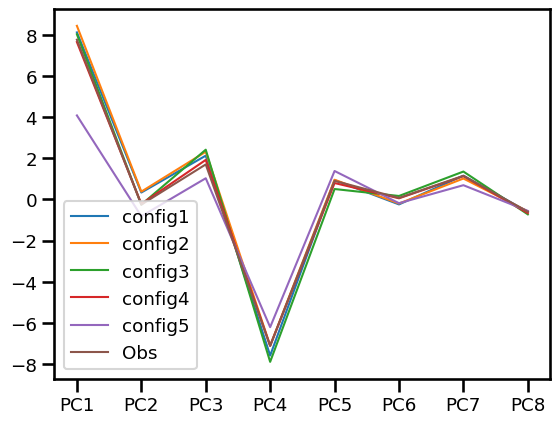

In [87]:
sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 1.5})

simusdftranspose.plot()

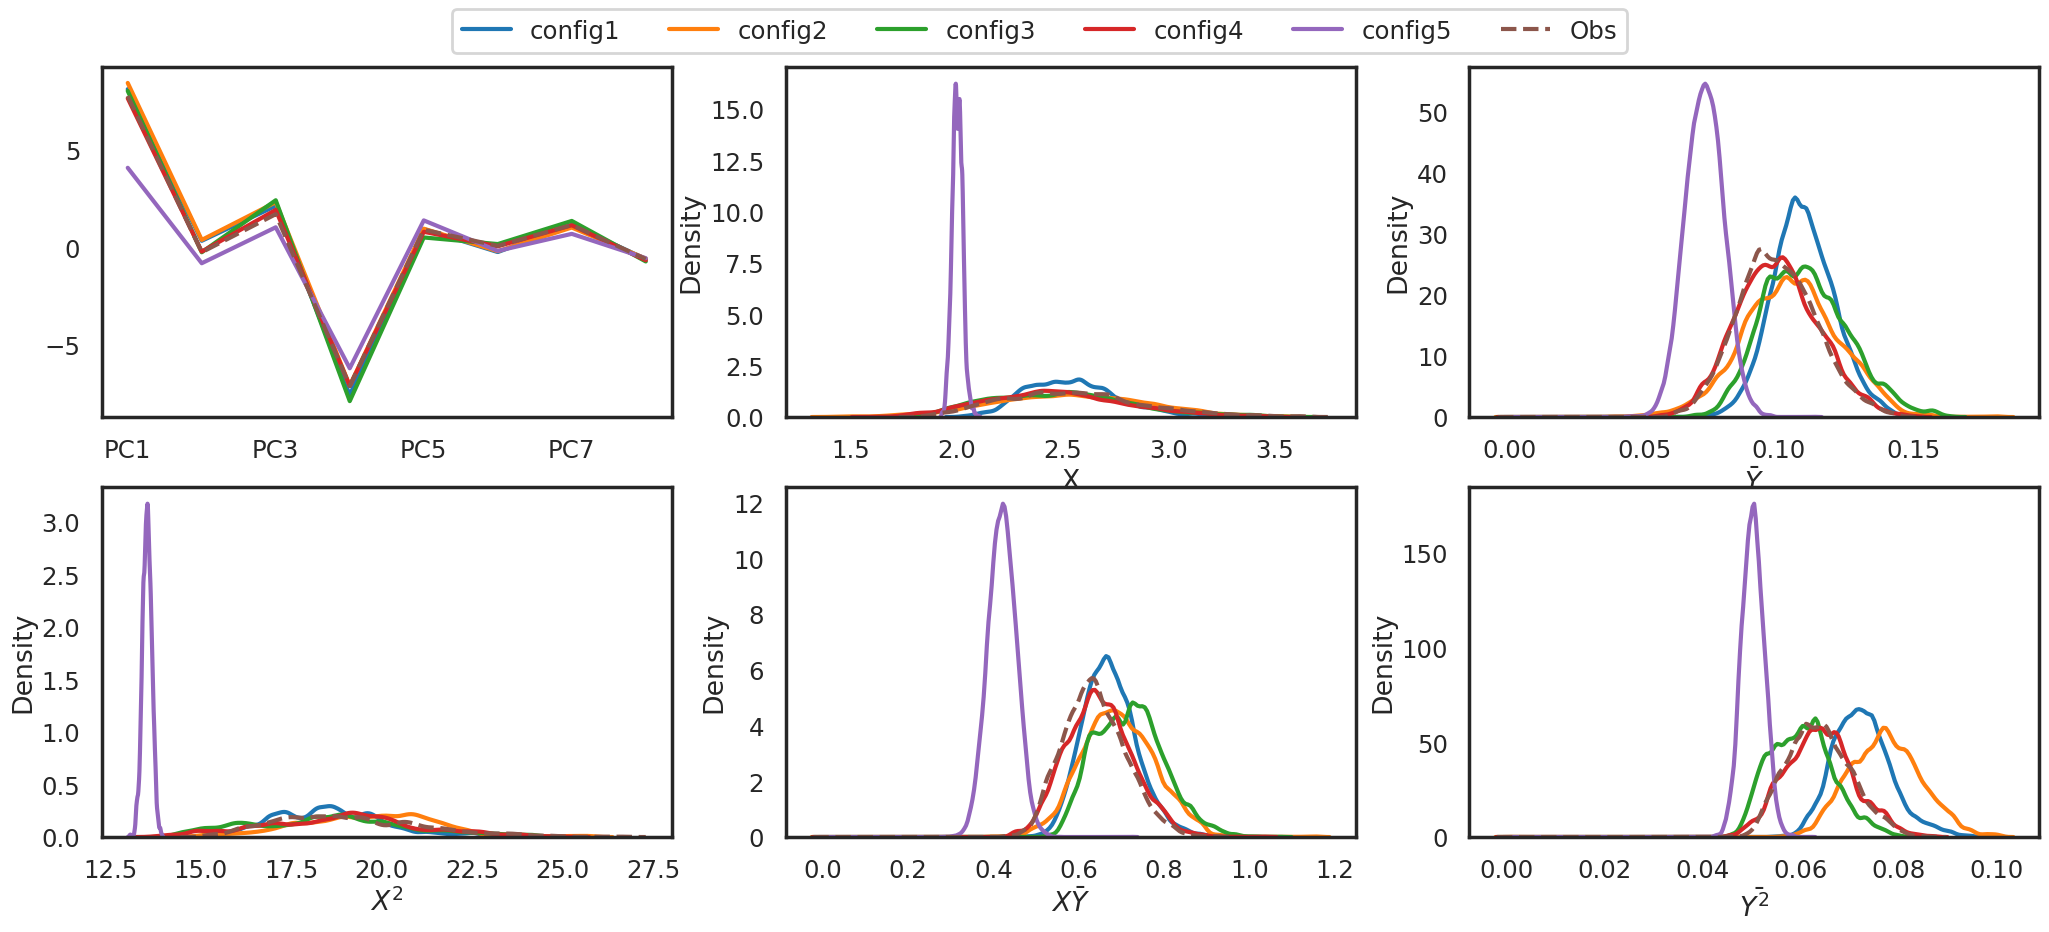

In [102]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(2, 3, figsize=(25,10))
simusdftranspose['config1'].plot(ax=axes[0,0])
simusdftranspose['config2'].plot(ax=axes[0,0])
simusdftranspose['config3'].plot(ax=axes[0,0])
simusdftranspose['config4'].plot(ax=axes[0,0])
simusdftranspose['config5'].plot(ax=axes[0,0])
simusdftranspose['Obs'].plot(linestyle="--", ax=axes[0,0])
#axes[0,0].legend()

sns.kdeplot(simus[0].history.X.mean(axis=1), label='config1', ax=axes[0,1])
sns.kdeplot(simus[1].history.X.mean(axis=1), label='config2', ax=axes[0,1])
sns.kdeplot(simus[2].history.X.mean(axis=1), label='config3', ax=axes[0,1])
sns.kdeplot(simus[3].history.X.mean(axis=1), label='config4', ax=axes[0,1])
sns.kdeplot(simus[4].history.X.mean(axis=1), label='config5', ax=axes[0,1])
sns.kdeplot(l96_two_truth.history.X.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[0,1])
#axes[0,1].legend()

sns.kdeplot(simus[0].history.Y_mean.mean(axis=1), label='config1', ax=axes[0,2])
sns.kdeplot(simus[1].history.Y_mean.mean(axis=1), label='config2', ax=axes[0,2])
sns.kdeplot(simus[2].history.Y_mean.mean(axis=1), label='config3', ax=axes[0,2])
sns.kdeplot(simus[3].history.Y_mean.mean(axis=1), label='config4', ax=axes[0,2])
sns.kdeplot(simus[4].history.Y_mean.mean(axis=1), label='config5', ax=axes[0,2])
sns.kdeplot(l96_two_truth.history.Y_mean.mean(axis=1), label='Obs', linestyle="--", ax=axes[0,2])
#axes[0,2].legend()
axes[0,2].set_xlabel(r'$\bar{Y}$')

sns.kdeplot((simus[0].history.X**2).mean(axis=1), label='config1', ax=axes[1,0])
sns.kdeplot((simus[1].history.X**2).mean(axis=1), label='config2', ax=axes[1,0])
sns.kdeplot((simus[2].history.X**2).mean(axis=1), label='config3', ax=axes[1,0])
sns.kdeplot((simus[3].history.X**2).mean(axis=1), label='config4', ax=axes[1,0])
sns.kdeplot((simus[4].history.X**2).mean(axis=1), label='config5', ax=axes[1,0])
sns.kdeplot((l96_two_truth.history.X**2).mean(axis=1), label='Obs', linestyle="--", ax=axes[1,0])
#axes[1,0].legend()
axes[1,0].set_xlabel(r'$X^2$')

sns.kdeplot((simus[0].history.X*simus[0].history.Y_mean).mean(axis=1), label='config1', ax=axes[1,1])
sns.kdeplot((simus[1].history.X*simus[1].history.Y_mean).mean(axis=1), label='config2', ax=axes[1,1])
sns.kdeplot((simus[2].history.X*simus[2].history.Y_mean).mean(axis=1), label='config3', ax=axes[1,1])
sns.kdeplot((simus[3].history.X*simus[3].history.Y_mean).mean(axis=1), label='config4', ax=axes[1,1])
sns.kdeplot((simus[4].history.X*simus[4].history.Y_mean).mean(axis=1), label='config5', ax=axes[1,1])
sns.kdeplot((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1), label='Obs', linestyle="--", ax=axes[1,1])
#axes[1,1].legend()
axes[1,1].set_xlabel(r'$X\bar{Y}$')

sns.kdeplot(simus[0].history.Y2_mean.mean(axis=1), label='config1', ax=axes[1,2])
sns.kdeplot(simus[1].history.Y2_mean.mean(axis=1), label='config2', ax=axes[1,2])
sns.kdeplot(simus[2].history.Y2_mean.mean(axis=1), label='config3', ax=axes[1,2])
sns.kdeplot(simus[3].history.Y2_mean.mean(axis=1), label='config4', ax=axes[1,2])
sns.kdeplot(simus[4].history.Y2_mean.mean(axis=1), label='config5', ax=axes[1,2])
sns.kdeplot(l96_two_truth.history.Y2_mean.mean(axis=1), label='Obs', linestyle="--", ax=axes[1,2])
#axes[1,2].legend()
axes[1,2].set_xlabel(r'$\bar{Y^2}$')

handles, labels = axes[1,2].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95),
          ncol=6, fancybox=True, shadow=False)

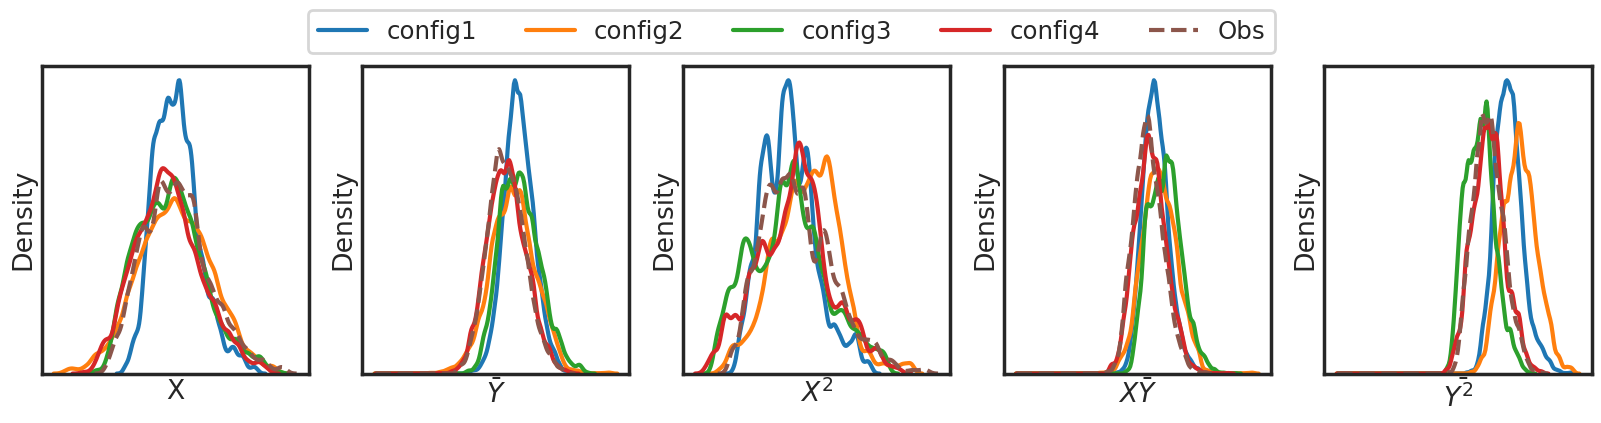

In [97]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(1, 5, figsize=(20,4))

sns.kdeplot(simus[0].history.X.mean(axis=1), label='config1', ax=axes[0])
sns.kdeplot(simus[1].history.X.mean(axis=1), label='config2', ax=axes[0])
sns.kdeplot(simus[2].history.X.mean(axis=1), label='config3', ax=axes[0])
sns.kdeplot(simus[3].history.X.mean(axis=1), label='config4', ax=axes[0])
sns.kdeplot(l96_two_truth.history.X.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[0])
#axes[0].legend()#loc='upper center', bbox_to_anchor=(0.5, 1.05),
          #ncol=3, fancybox=True, shadow=True)
axes[0].set_xticks([])
axes[0].set_yticks([])

sns.kdeplot(simus[0].history.Y_mean.mean(axis=1), label='config1', ax=axes[1])
sns.kdeplot(simus[1].history.Y_mean.mean(axis=1), label='config2', ax=axes[1])
sns.kdeplot(simus[2].history.Y_mean.mean(axis=1), label='config3', ax=axes[1])
sns.kdeplot(simus[3].history.Y_mean.mean(axis=1), label='config4', ax=axes[1])
sns.kdeplot(l96_two_truth.history.Y_mean.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[1])
#axes[1].legend()
axes[1].set_xlabel(r'$\bar{Y}$')
axes[1].set_xticks([])
axes[1].set_yticks([])

sns.kdeplot((simus[0].history.X**2).mean(axis=1), label='config1', ax=axes[2])
sns.kdeplot((simus[1].history.X**2).mean(axis=1), label='config2', ax=axes[2])
sns.kdeplot((simus[2].history.X**2).mean(axis=1), label='config3', ax=axes[2])
sns.kdeplot((simus[3].history.X**2).mean(axis=1), label='config4', ax=axes[2])
sns.kdeplot((l96_two_truth.history.X**2).mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[2])
#axes[2].legend()
axes[2].set_xlabel(r'$X^2$')
axes[2].set_xticks([])
axes[2].set_yticks([])

sns.kdeplot((simus[0].history.X*simus[0].history.Y_mean).mean(axis=1), label='config1', ax=axes[3])
sns.kdeplot((simus[1].history.X*simus[1].history.Y_mean).mean(axis=1), label='config2', ax=axes[3])
sns.kdeplot((simus[2].history.X*simus[2].history.Y_mean).mean(axis=1), label='config3', ax=axes[3])
sns.kdeplot((simus[3].history.X*simus[3].history.Y_mean).mean(axis=1), label='config4', ax=axes[3])
sns.kdeplot((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[3])
#axes[3].legend()
axes[3].set_xlabel(r'$X\bar{Y}$')
axes[3].set_xticks([])
axes[3].set_yticks([])

sns.kdeplot(simus[0].history.Y2_mean.mean(axis=1), label='config1', ax=axes[4])
sns.kdeplot(simus[1].history.Y2_mean.mean(axis=1), label='config2', ax=axes[4])
sns.kdeplot(simus[2].history.Y2_mean.mean(axis=1), label='config3', ax=axes[4])
sns.kdeplot(simus[3].history.Y2_mean.mean(axis=1), label='config4', ax=axes[4])
sns.kdeplot(l96_two_truth.history.Y2_mean.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[4])
#axes[4].legend()
axes[4].set_xlabel(r'$\bar{Y^2}$')
axes[4].set_xticks([])
axes[4].set_yticks([])

handles, labels = axes[4].get_legend_handles_labels()
figure.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=False)

In [42]:
from scipy.stats import entropy

def KL_div_obs(sim):
    rangex=(l96_two_truth.history.X.mean(axis=1).min().values,
       l96_two_truth.history.X.mean(axis=1).max().values)
    rangeym=(l96_two_truth.history.Y_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y_mean.mean(axis=1).max().values)
    rangexsq=((l96_two_truth.history.X**2).mean(axis=1).min().values,
       (l96_two_truth.history.X**2).mean(axis=1).max().values)
    rangexym=((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1).min().values,
       (l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1).max().values)
    rangeymsq=(l96_two_truth.history.Y2_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y2_mean.mean(axis=1).max().values)
    return np.median([entropy(np.histogram(sim.history.X.mean(axis=1), range=rangex)[0],
                          np.histogram(l96_two_truth.history.X.mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y_mean.mean(axis=1), range=rangeym)[0],
                          np.histogram(l96_two_truth.history.Y_mean.mean(axis=1))[0]),
                  entropy(np.histogram((sim.history.X**2).mean(axis=1), range=rangexsq)[0],
                          np.histogram((l96_two_truth.history.X**2).mean(axis=1))[0]),
                  entropy(np.histogram((sim.history.X*sim.history.Y_mean).mean(axis=1), range=rangexym)[0],
                          np.histogram((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y2_mean.mean(axis=1), range=rangeymsq)[0],
                          np.histogram(l96_two_truth.history.Y2_mean.mean(axis=1))[0])])

In [43]:
KL_div_obs(l96_two_truth)

0.0

In [59]:
[KL_div_obs(sim) for sim in simus]

/linkhome/rech/genloc01/udu91zn/.conda/envs/redouaneML/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


[0.26129910010093976,
 0.3698129987773661,
 0.19069573077156476,
 0.015605092343829355,
 nan]

In [44]:
[KL_div_obs(sim) for sim in simus]

[0.13408744391668942,
 0.0870951777909423,
 0.1511944548065236,
 0.013458522756187665,
 nan]

In [95]:
configs

array([[ 0.98865725, 11.89840024, 16.20839684,  9.16880713],
       [ 1.15251025,  8.93587769,  3.93565147, 10.33338904],
       [ 0.57698978, 10.31054995, 11.8991103 ,  6.8907023 ],
       [ 0.92171056, 10.31289674, 10.2755616 ,  9.35218113],
       [ 1.86934714, 11.52220415, 19.03396845, 15.65491734]])